<a href="https://colab.research.google.com/github/arnauldnzegha/DeepFR_tensorflow_keras_callab/blob/master/Augmented_data_3Dface_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reffer to https://github.com/arnauldnzegha/calculate_verticesNormal_3D_face__lightAugmentation.git for data augentation 

In [ ]:

#*******************MY MODEL***********************************************
def my_model(include_top=True, nb_person=10):
    img_input = Input(shape=(100, 100, 3))
    #Block 1 avec 64 filtre
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='conv1_1')(img_input)
    x=BatchNormalization()(x)
    x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='conv1_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)
    x= Dropout(0.25)(x)

    # Block 2
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='conv2_1')(x)
    x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='conv2_2')(x)
    x=BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)
    x= Dropout(0.25)(x)

    # Block 3
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='conv3_1')(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='conv3_2')(x)
    x=BatchNormalization()(x)
    x = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='conv3_3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)
    x= Dropout(0.25)(x)

    # Block 4
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv4_1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv4_2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv4_3')(x)
    x=BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)
    x= Dropout(0.25)(x)

    # Block 5
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv5_1')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv5_2')(x)
    x = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='conv5_3')(x)
    x=BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)
    x= Dropout(0.25)(x)

    #Classifieur du modele
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc6')(x)
    x= Dropout(0.25)(x)
    x = Dense(4096, activation='relu', name='fc7')(x)
    x = Dense(nb_person, activation='softmax', name='fc8')(x)
    model = Model(img_input, x)
    return model
#*******************END MY MODEL*****************************************************************


#TEST ON YALE-B


In [ ]:
##*****************LOAD AND UNZIP******************************
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#SIMP 300
zip_id = '1OBtpoaZCnHNONSXlqnrwU2hgFV-9NeCP'
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('model_weights_SIMP.h5')
#Aug 1000
zip_id2 = '1nWnPKtxbPeFjrWuJN2pPCHKG_PyvyXH7'
myzip = drive.CreateFile({'id': zip_id2})
myzip.GetContentFile('model_weights_AUG.h5')

In [ ]:
##*****************LOAD AND UNZIP******************************
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#yaleB
zip_id = '1JmTI7bdp49q44PDz-m08rCifxTHCpcCo'
if not os.path.exists('DATA2'):
    os.makedirs('DATA2')
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('model.zip')
zip_ref = zipfile.ZipFile('model.zip', 'r')
zip_ref.extractall('DATA2/')
zip_ref.close()

In [ ]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from keras.utils import np_utils
import warnings
import matplotlib.pyplot as plt
from keras.models import Model
from keras.optimizers import SGD,Adadelta
from keras.layers import Flatten, Dense, Convolution2D, MaxPooling2D, Input, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import backend as K
from random import shuffle
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import numpy as np
import cv2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


def load_trainSet():
    root="DATA2/yalefacesCrp"
    folders = os.listdir(root)
    nb = len(folders)
    x_data, x_test=[], []
    y_label, y_test=[], []
    for x in range(nb):
        label=np.zeros(nb)
        label[x]=1
        facesPath=os.listdir(root+"/"+folders[x])
        faces=[root+"/"+folders[x]+"/"+f for f in facesPath if f.endswith(".png")]
        facesL=[root+"/"+folders[x]+"/"+f for f in facesPath if f.endswith("light.png")]
        faces=[f for f in faces if f not in facesL]
        for face in faces:
            img=cv2.imread(face)
            x_data.extend([img])
            y_label.extend([label])
        for face in facesL:
            img=cv2.imread(face)
            x_test.extend([img])
            y_test.extend([label])
    return np.asarray(x_data), np.asarray(y_label), np.asarray(x_test), np.asarray(y_test), nb

def mixData(xs,ys):
    xys=[]
    for i in range(0,len(xs)-1):
        xys.append((xs[i],ys[i]))
    shuffle(xys)
    x2,y2=[],[]
    for (x,y) in xys:
        x2.append(x)
        y2.append(y)
    return (np.asarray(x2), np.asarray(y2))




#*******************MAIN*************************************************************************
if __name__ == '__main__':
    from scipy import misc
    import copy
    x_train, y_train, x_test, y_test, nb_class=load_trainSet()
    (x_train, y_train)=mixData(x_train, y_train)
    model = my_model(nb_person=10)
    model.load_weights('model_weights_AUG.h5')
    #*******************************************************
    img_input = Input(shape=(100, 100, 3))
    x = model.get_layer("pool5").output
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc6')(x)
    x= Dropout(0.25)(x)
    x = Dense(4096, activation='relu', name='fc7')(x)
    x = Dense(nb_class, activation='softmax', name='fc8')(x)
    model2 = Model(model.input, x)
    #*******************************************************
    for layer in model2.layers[:-4]:
        layer.trainable = False
    #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    delta=Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    model2.compile(loss='categorical_crossentropy', optimizer=delta,  metrics=['accuracy'])
    print("Entrainement du modele")
    hist=model2.fit(x_train, y_train, validation_split=0.33, batch_size=32, epochs=1000, verbose=1)
    print("evaluation")
    score = model2.evaluate(x_test, y_test, batch_size=32)
    print(score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1", padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_1", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_2", padding="same")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `

Entrainement du modele
Train on 80 samples, validate on 40 samples
Epoch 1/1000
80/80 [==============================] - 2s 21ms/step - loss: 7.5812 - acc: 0.1750 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 2/1000
80/80 [==============================] - 0s 3ms/step - loss: 13.2405 - acc: 0.1750 - val_loss: 13.2673 - val_acc: 0.1500
Epoch 3/1000
80/80 [==============================] - 0s 3ms/step - loss: 12.1096 - acc: 0.2125 - val_loss: 15.3122 - val_acc: 0.0500
Epoch 4/1000
80/80 [==============================] - 0s 3ms/step - loss: 13.3462 - acc: 0.1500 - val_loss: 14.1184 - val_acc: 0.1000
Epoch 5/1000
80/80 [==============================] - 0s 3ms/step - loss: 12.8243 - acc: 0.1750 - val_loss: 12.9636 - val_acc: 0.1750
Epoch 6/1000
80/80 [==============================] - 0s 3ms/step - loss: 10.8419 - acc: 0.3125 - val_loss: 13.2691 - val_acc: 0.1250
Epoch 7/1000
80/80 [==============================] - 0s 3ms/step - loss: 10.8211 - acc: 0.3125 - val_loss: 10.7281 - val_acc: 0.

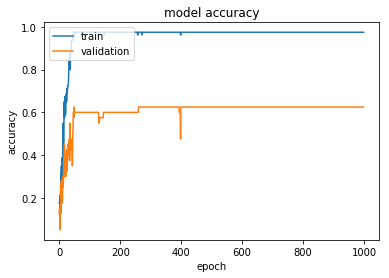

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()